Solving track reconstruction
=======================

Up until now, we have created tracks. However, tracks should fulfill some criteria in order to make sense from a physical standpoint: It wouldn't make sense to have several tracks coming from the same hits, or to join random hits together.

Typically one uses known geometrical constraints alongside problem-specific knowledge in order to determine where to look for tracks, and how should tracks look like. Ultimately, there are five quantities one has to look after:


*   Reconstruction Efficiency: The fraction of particles we have reconstructed.
    > \# correctly reconstructed / \# real tracks

*   Clone Tracks: Tracks that are similar to other correctly reconstructed tracks.
    > \# clone tracks / \# correctly reconstructed

*   Fake Tracks: Tracks that are incorrect, either created by noise hits or by incorrectly reconstructing a track.
    > \# incorrectly reconstructed / \# all reconstructed

*   Hit purity: Fraction of hits in a track that belong to the same MC particle.
    > \# track hits in MC particle hits / \# track hits
    
*   Hit efficiency: Number of hits correctly found out of the MC particle hits in a track.
    > \# track hits in MC particle hits / \# MC particle hits

Phew, that was quite a mouthful. If you want one thing to look for at the beginning, that is to *maximize reconstruction efficiency*. First try to reconstruct as much correct as possible, and work out the other indicators one by one.

Alongside the velopix tracking project there are a few algorithms we can try:

In [3]:
# Run this if you didn't run it previously
!git clone https://github.com/dcampora/velopix_tracking.git

fatal: destination path 'velopix_tracking' already exists and is not an empty directory.


In [4]:
import sys, os
sys.path.append(os.getcwd() + "/../")
sys.path.append(os.getcwd() + "/velopix_tracking/")

import json
from velopix_tracking.event_model import event_model as em

f = open("velopix_tracking/events/velo_event_0.json")
json_data = json.loads(f.read())
event = em.event(json_data)
f.close()

Track following is a technique that reconstructs hits by visiting neighbouring modules. One first creates tracklets or *seeds* and posteriorly follows those tracks until no more hits are found.

<img src="velopix_tracking/doc/reco_example.png" alt="Track follow example" />

Included with the project is a track following implementation. Let's check it out.

In [5]:
from velopix_tracking.algorithms.track_following import track_following

# Instantiate track following
track_following = track_following()

# Solve the event
tracks = track_following.solve(event)

print("Found %i tracks with track following!" % len(tracks))

Instantiating track_following solver with parameters
 max slopes: (0.7, 0.7)
 max tolerance: (0.4, 0.4)
 max scatter: 0.4

Found 148 tracks with track following!


Track following found tracks, but are these the good tracks? For that, we will need to employ a validator:

In [6]:
from velopix_tracking.validator import validator_lite as vl
vl.validate_print([json_data], [tracks])

148 tracks including        8 ghosts (  5.4%). Event average   5.4%
              velo :      126 from      134 ( 94.0%,  94.0%)        3 clones (  2.38%), purity: ( 98.83%,  98.83%),  hitEff: ( 93.89%,  93.89%)
              long :       22 from       22 (100.0%, 100.0%)        1 clones (  4.55%), purity: ( 99.52%,  99.52%),  hitEff: ( 93.80%,  93.80%)
         long>5GeV :        8 from        8 (100.0%, 100.0%)        0 clones (  0.00%), purity: (100.00%, 100.00%),  hitEff: (100.00%, 100.00%)


Results are shown for different track categories. Track categories are detector-specific, and refer to different types of tracks depending on the subdetectors they traverse, their energy, the particle decay where they originated from, direction, etc.

<img src="docs/track_types.png" alt="Track follow example" style="width: 600px" />

In the previous case, you can see some tracks are "velo" tracks or "long" tracks, which you can interpret from the image above.

Exercise 2
---------------

Let's first visualize what just happened.

* Use `print_event_2d` to print the event, and then print the event with the tracks found by `track_following`.

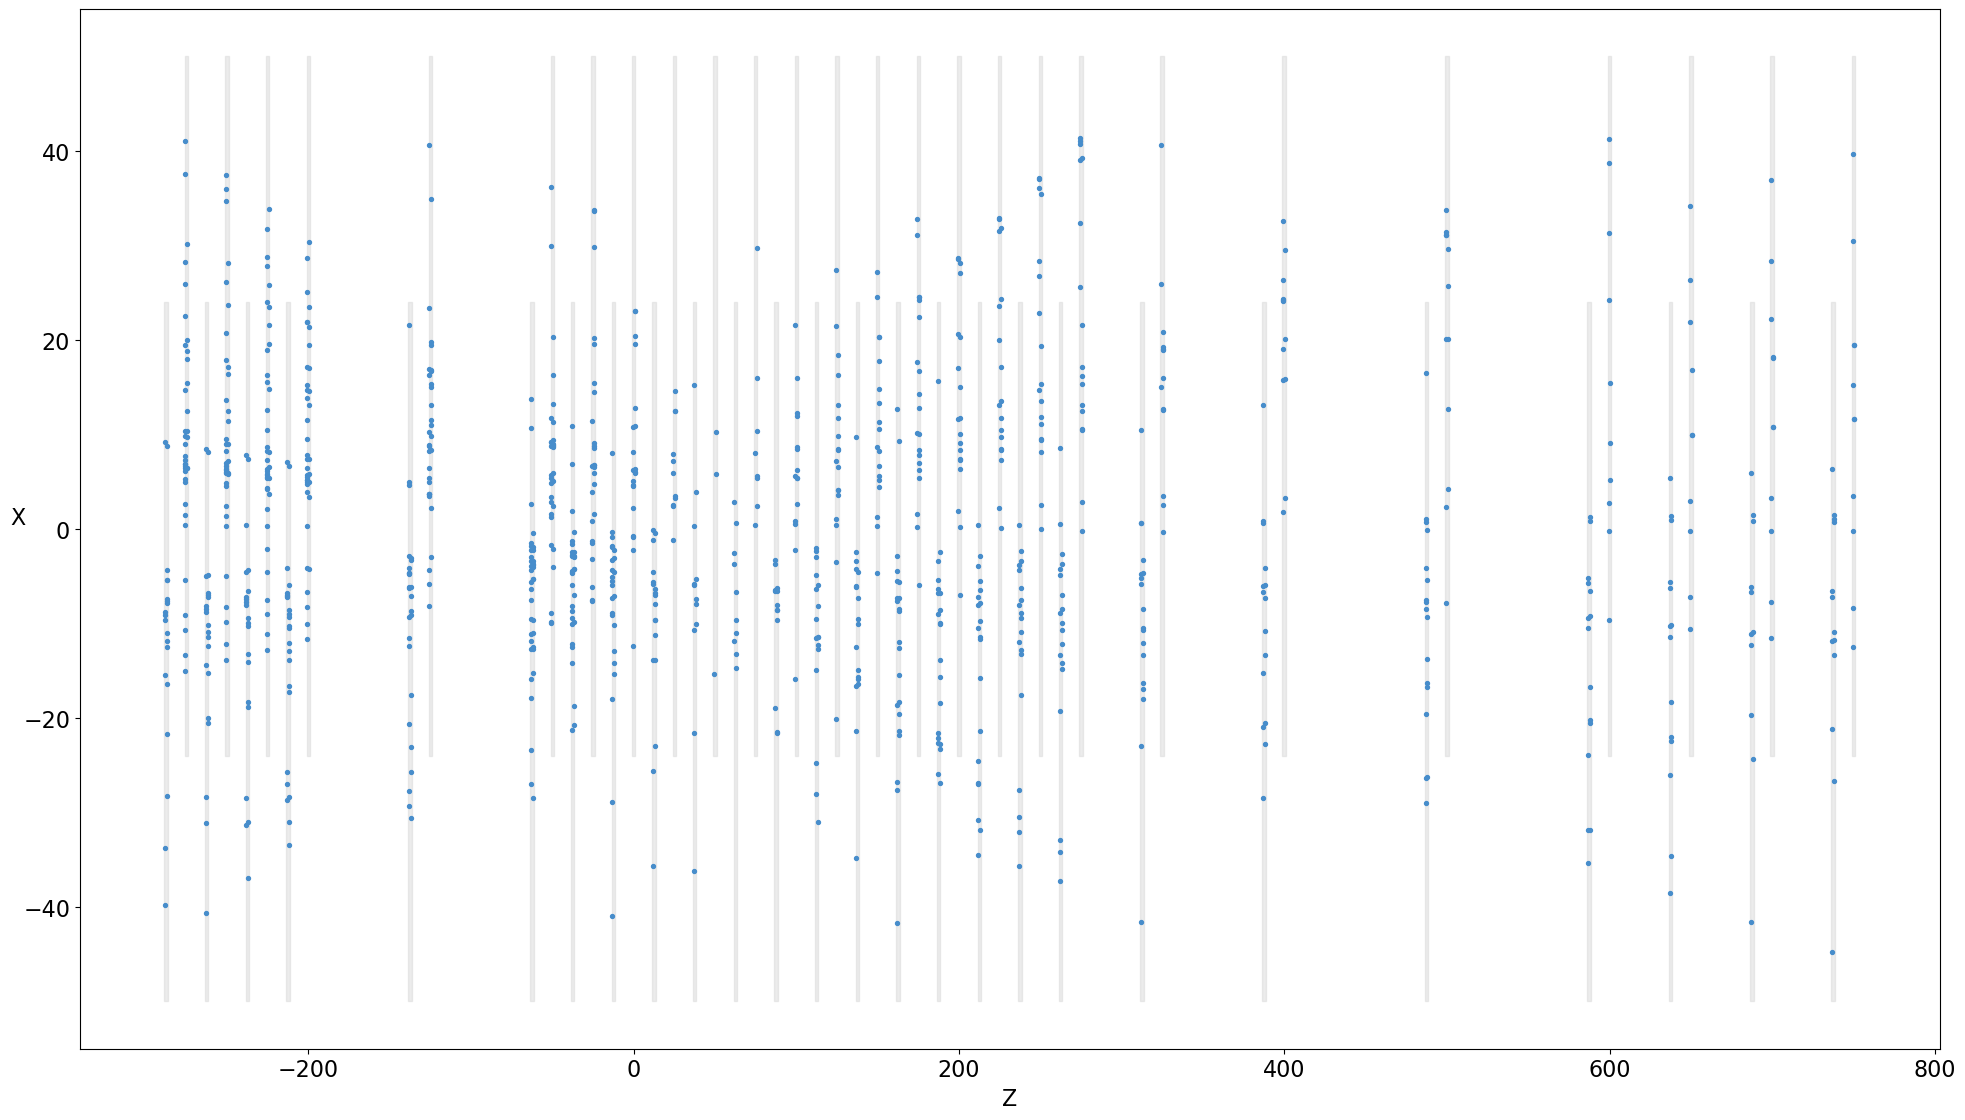

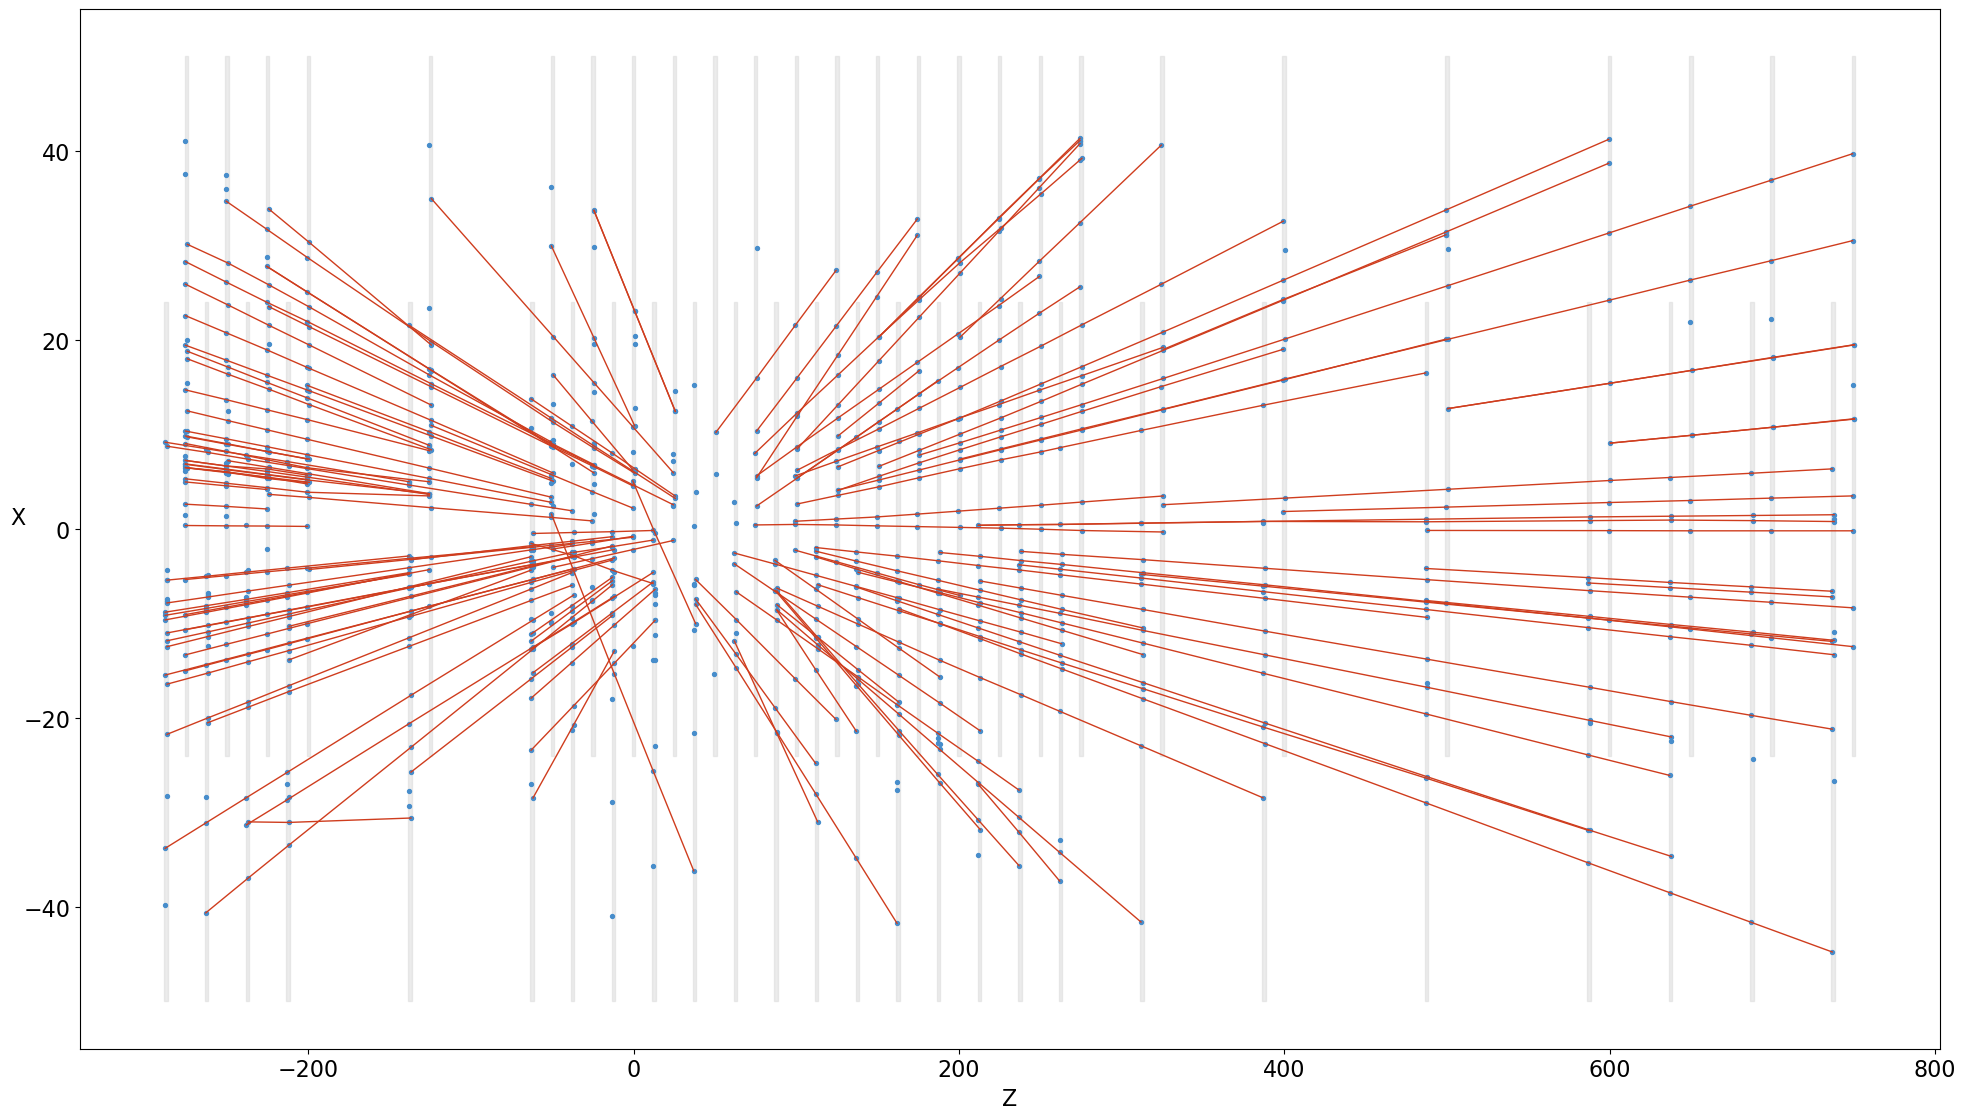

In [7]:
from velopix_tracking.visual.base import print_event_2d
%matplotlib inline
print_event_2d(event) # this plots the event 

print_event_2d(event, tracks) # this plots the event with tracks


* The statistics we have are insufficient. Load iteratively all 10 events and run `track_following` on them. Finally, run the validator once with all the `json` data and all tracks. Do the numbers correspond with the previous ones?

In [8]:
# Each event has a number of tracks 
#create empty all
appended_json_data = []
appended_tracks = []
for i in range(10): #for each of the 10 events
    #load each individual event
    with open(f"velopix_tracking/events/velo_event_{i}.json") as ff:

    #read each individual event
        json_dataf = json.loads(ff.read())

    # make event an object
    eventf = em.event(json_dataf)

    #build tracks from each object
    tracksf = track_following.solve(eventf)
    
    appended_json_data.append(json_dataf)
    appended_tracks.append(tracksf)


vl.validate_print(appended_json_data, appended_tracks)




2759 tracks including      273 ghosts (  9.9%). Event average   8.5%
              velo :     2181 from     2377 ( 91.8%,  93.0%)       52 clones (  2.38%), purity: ( 98.07%,  98.20%),  hitEff: ( 94.46%,  94.58%)
              long :      640 from      654 ( 97.9%,  98.5%)       27 clones (  4.22%), purity: ( 98.34%,  98.72%),  hitEff: ( 93.95%,  94.04%)
         long>5GeV :      391 from      401 ( 97.5%,  98.4%)       20 clones (  5.12%), purity: ( 98.10%,  98.68%),  hitEff: ( 94.25%,  93.20%)
      long_strange :       24 from       26 ( 92.3%,  93.7%)        0 clones (  0.00%), purity: ( 97.80%,  96.96%),  hitEff: ( 95.15%,  97.02%)
 long_strange>5GeV :       10 from       11 ( 90.9%,  91.5%)        0 clones (  0.00%), purity: ( 99.00%,  99.33%),  hitEff: ( 94.81%,  95.07%)
        long_fromb :        9 from        9 (100.0%, 100.0%)        0 clones (  0.00%), purity: (100.00%, 100.00%),  hitEff: ( 98.57%,  98.41%)
   long_fromb>5GeV :        4 from        4 (100.0%, 100.0%)       

The fake rate is a big higher than expected. It could be that some of the tracks with less hits are incorrect.

* Remove all tracks with 3 hits and run the validator. Do the results improve? What are the tradeoffs?

In [9]:
# explanation for myself: each track is recontructed with recontructing the data that jits each detector layer
#usually short tracks (aka a few hits like 3 here ) may be miscontructed tracks or noise 
#these increase the fake rate and they dont show real particle trajectories
# so therefore longer tracks are more relaible
#each event has tracks -> each track has hits

filtered_tracks = []

for event_tracks in appended_tracks: # event tracks are the tracks of a specific event (from 1 to 10)
    accepted_tracks = [
          individual_track for individual_track in event_tracks # for individual tracks in an event
          if len(individual_track.hits) > 3] # add to list if hits are grater than 3
    
    filtered_tracks.append(accepted_tracks) # add to flitered tracks list

vl.validate_print(appended_json_data, filtered_tracks) # validate the fake rate of filtered tracks

2288 tracks including      121 ghosts (  5.3%). Event average   4.3%
              velo :     1914 from     2377 ( 80.5%,  81.7%)       40 clones (  2.09%), purity: ( 97.79%,  97.98%),  hitEff: ( 94.98%,  94.99%)
              long :      624 from      654 ( 95.4%,  96.8%)       24 clones (  3.85%), purity: ( 98.29%,  98.68%),  hitEff: ( 94.62%,  94.37%)
         long>5GeV :      387 from      401 ( 96.5%,  97.4%)       18 clones (  4.65%), purity: ( 98.07%,  98.66%),  hitEff: ( 95.06%,  93.64%)
      long_strange :       21 from       26 ( 80.8%,  78.0%)        0 clones (  0.00%), purity: ( 97.49%,  96.71%),  hitEff: ( 95.79%,  97.79%)
 long_strange>5GeV :        8 from       11 ( 72.7%,  67.7%)        0 clones (  0.00%), purity: ( 98.75%,  99.00%),  hitEff: ( 96.14%,  96.96%)
        long_fromb :        7 from        9 ( 77.8%,  78.9%)        0 clones (  0.00%), purity: (100.00%, 100.00%),  hitEff: ( 98.21%,  97.96%)
   long_fromb>5GeV :        4 from        4 (100.0%, 100.0%)       

Exercise 4
---------------

If you still have energy in you, with everything you have learned you have now the tools to attempt creating your own track reconstruction algorithm.

We will first need a function to determine whether a track looks good or bad. One such function is the *means squared error*:

* Create a means_squared_error method that gets a track as an input and calculates the MSE (https://en.wikipedia.org/wiki/Mean_squared_error) of a track.

In [10]:
#measuring how far the hits are from the fitted line
# if the sme is small then the track fits well and if tis large then its probably a fake track

import numpy as np

def means_squared_error(track):
    x = np.array([hit.x for hit in track.hits]) #position
    y = np.array([hit.y for hit in track.hits])
    z = np.array([hit.z for hit in track.hits]) # position along depth of detector 
    
    # fit line in xz plane
    a_x, b_x = np.polyfit(z, x, 1) #fins slope and intercept using y = ax +b
    predicted_x = a_x * z + b_x
    squared_errors_x = (x - predicted_x) ** 2
    
    # fit line in yz plane
    a_y, b_y = np.polyfit(z, y, 1)  
    predicted_y = a_y * z + b_y
    squared_errors_y = (y - predicted_y) ** 2
    
    # combine MSEs
    mse_total = np.mean(squared_errors_x + squared_errors_y)
    
    return mse_total


Now that you have a function to qualify how good a track is *you are in business*. A rough approximation at a tracking in the VELO is as follows:

1. Iterate over 3 modules until you find a *triplet* of hits whose MSE is under a threshold.
2. Extrapolate those hits to the remaining modules until you find no compatible hits with the MSE method in a module.

Implement such a tracking algorithm, and have fun playing around with the data!

35 tracks including       35 ghosts (100.0%). Event average 100.0%
              velo :        0 from      134 (  0.0%,   0.0%)        0 clones (  0.00%), purity: (  0.00%,   0.00%),  hitEff: (  0.00%,   0.00%)
              long :        0 from       22 (  0.0%,   0.0%)        0 clones (  0.00%), purity: (  0.00%,   0.00%),  hitEff: (  0.00%,   0.00%)
         long>5GeV :        0 from        8 (  0.0%,   0.0%)        0 clones (  0.00%), purity: (  0.00%,   0.00%),  hitEff: (  0.00%,   0.00%)


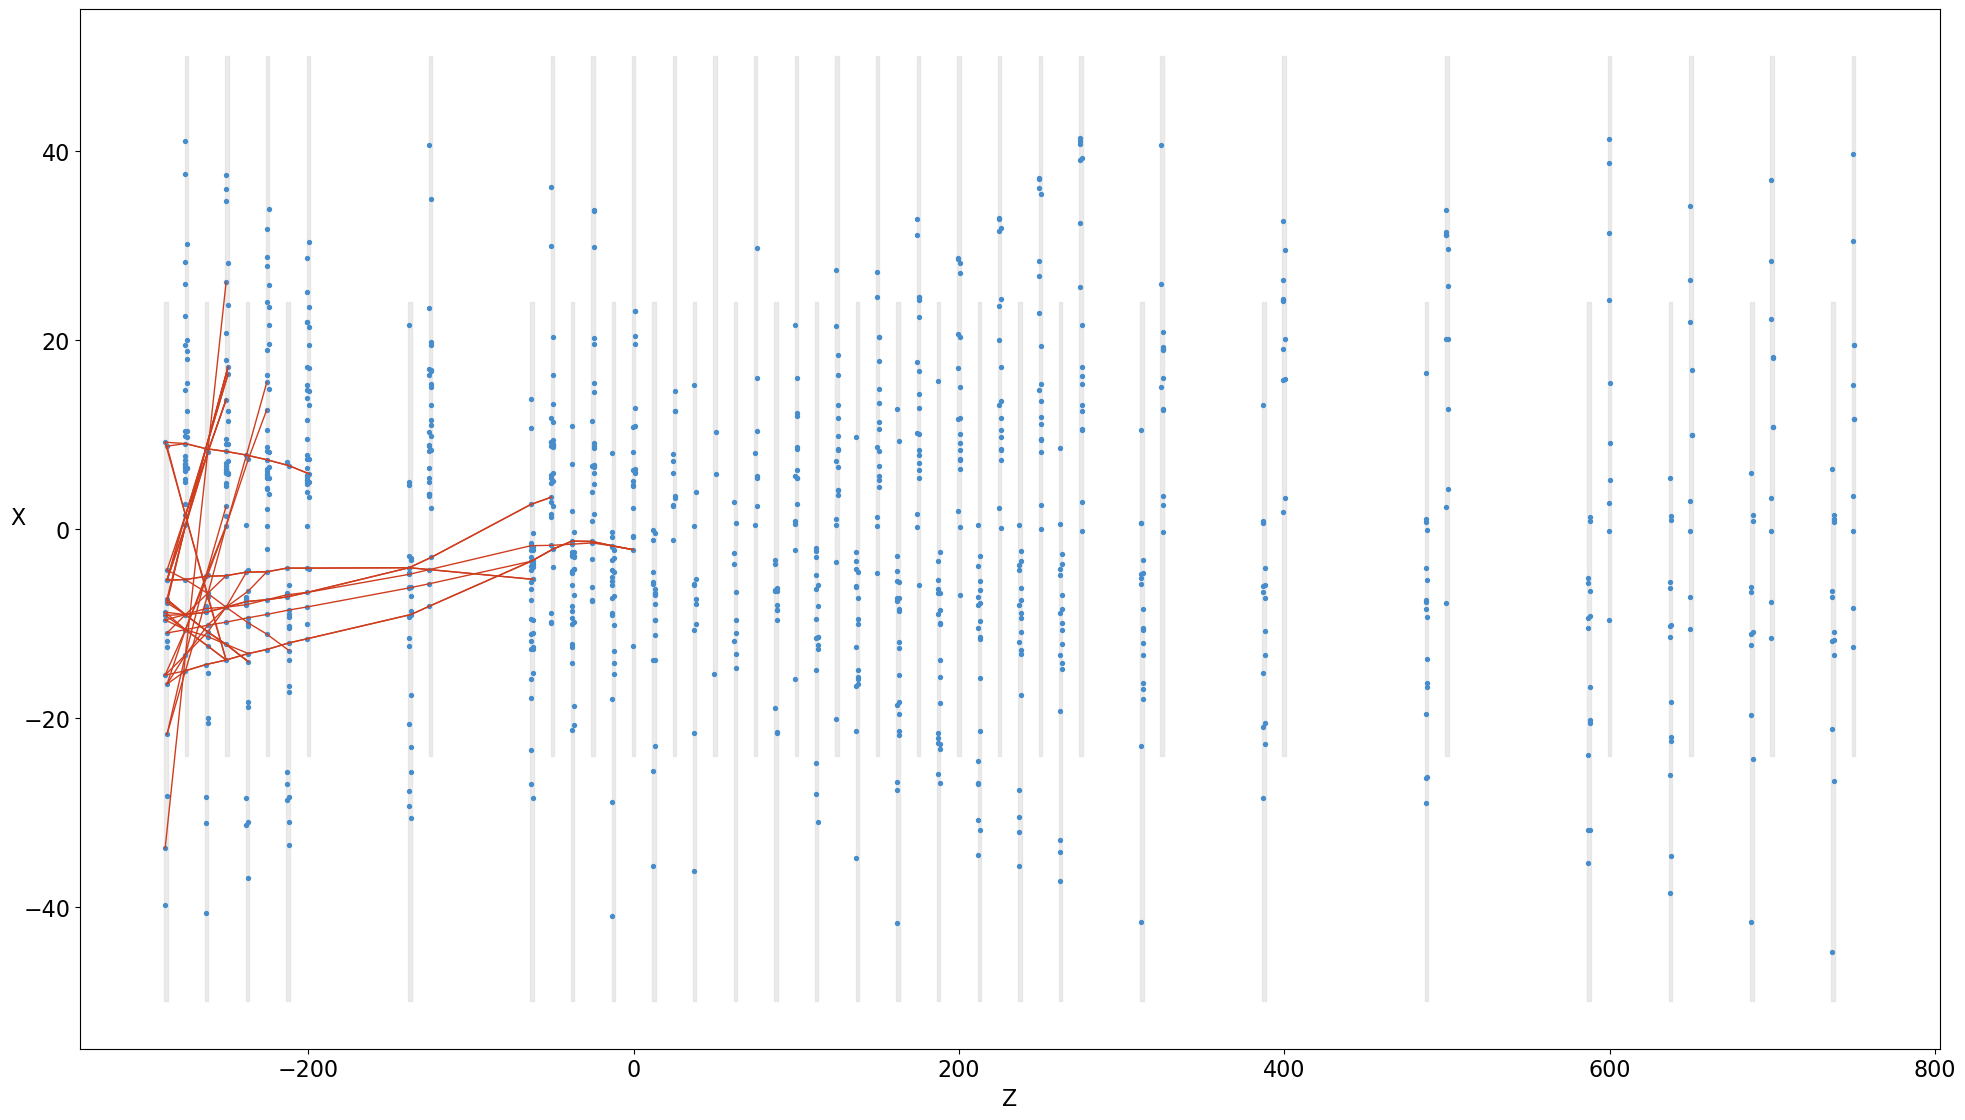

In [29]:
import numpy as np

#here we take two points, find their slope and extend the line 
#on xz plane bc were tracking across the depth of the detector
def predict_xz(hit1, hit2, z): # Hits inputs, and z is target position
    dz = hit2.z - hit1.z #distance between hits
    if dz == 0:
        return None
    slope = (hit2.x - hit1.x) / dz #find slope
    return hit2.x + slope * (z - hit2.z) # linear extrapolation

def tracking_algorithm(modules, max_residual=1.0, min_hits=4):
#modules list of hits
#max_residual= 

    tracks = []

    module0 = modules[0] #all hits in module 1
    module1 = modules[1] # all hiits in module 2

    for h0 in module0:
        for h1 in module1:
            track = Track(hits=[h0, h1]) # define track with two hits

            for m in range(2, len(modules)): # from 2 to all hits in modules
                best_hit = None
                best_dist = max_residual

                for hit in modules[m]: # loop over all the hits in the module
                    x_pred = predict_xz(track.hits[-2], track.hits[-1], hit.z)
                    
                    dist = abs(hit.x - x_pred) #compute residual between measured and predicted hit
                    if dist < best_dist:
                        best_dist = dist
                        best_hit = hit
                    
                if best_hit is not None:
                    track.add_hit(best_hit)
                else:
                    break
                

            if len(track.hits) >= min_hits:
                tracks.append(track)

    return tracks
reconstructed_tracks = tracking_algorithm(
    modules=event.modules,
    max_residual=1.0,
    min_hits=4
)


reconstructed_tracks
vl.validate_print([json_data], [reconstructed_tracks])

print_event_2d(event, reconstructed_tracks)
